In [17]:
am_scale = 1

In [18]:
import setup; import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
from speech_pause_indicator import speech as original_speech

In [19]:
##https://pyts.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw.html
from pyts.datasets import load_gunpoint; import math
from pyts.metrics import dtw, itakura_parallelogram, sakoe_chiba_band
from pyts.metrics.dtw import (cost_matrix, accumulated_cost_matrix, _return_path, _blurred_path_region)
import itertools; import statistics

In [20]:
# pyts - classic dtw
def classic(x, y, xlabel, ylabel, time1_lst, time2_lst, sr, speech_x, speech_y):
    method = 'classic'
    dtw_classic, path_classic = dtw(x, y, dist='absolute', method=method, return_path=True)
    path = path_classic
    dist = dtw_classic
    
    return path, dist, method

In [21]:
def downsample(query, ratio):
    
    # Scale the amplitudes by dividing each amplitude over the largest amplitude magnitude
    max_m = np.abs(max(query))
    res = []
    for i in range(int(len(query) // ratio)):
        if int(i*ratio) < len(query):
            res.append(query[int(i*ratio)]/max_m)
    return res

In [22]:
# Maximum dtw distance = number of points in the alignment path * largest difference between amplitude of x and y

def normalize_distance(x, y, path, dist, method, am_scale = am_scale):
    plt.figure(figsize=(5, 3))
    nor_dist = dist / (am_scale * 2* len(path[0]))
    return nor_dist
    
# unit of distance = amplitude / portion of the alignment path

In [23]:
def alignment_err(x, y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech1, speech2, dist, method):
    
    nor_dist = normalize_distance(x, y, path, dist, method)
    colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']
    err = []
    for i in range(len(time1_lst)):
        x_axis, y_axis = get_word_xy(x, y, time1_lst[i], seg1_1, seg1_2, time2_lst[i], seg2_1, seg2_2)
        plt.scatter(x_axis, y_axis, color = colors[i], marker = "X", edgecolor = 'black', s = 100)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        
        x_val = list(itertools.chain(*np.where(np.abs(path[0] - x_axis) < 0.5)))[0]
        y_val = list(itertools.chain(*np.where(np.abs(path[1] - y_axis) < 0.5)))[0]

        warp_y = path[1][x_val]
        warp_x = path[0][y_val]
        
        e = (np.abs(warp_x - x_axis) + np.abs(warp_y - y_axis))/sr
        err.append(e)    # unit = second
        
    median = statistics.median(err)
    err_sum = sum(err)
    
    plt.title('dtw %s distance: %.10f' %(method, nor_dist));    
    plt.plot(path[0], path[1]);    
    
    text1 = 'Avg err (s): %.3f. \nMedian err (s): %.3f' %(err_sum/len(time1_lst), median)
    text2 = '\nStretch speech: %.3f \nStretch pause: %.3f. \nStretch unaligned: %.3f. \nStretch overall: %.3f.' %stretch(path, speech1, speech2)    

    # print text
    plt.text(max(path[0]) + 2000, 0, text1+text2, fontsize=14)
    plt.grid(True)
    plt.subplots_adjust(right = 1)

In [24]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, am_scale = am_scale, **kwargs):
    
    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', None)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(original_query[int(samplerate*0.5): int(samplerate*0.5 + frame_per_window)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]*max_am) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result

In [63]:
a = [1, 2, 3, 4, 5, 6, 7, 8, 9]
a[a[0]:a[1]]= [1] * (a[1] - a[0])
print(a)

[1, 1, 3, 4, 5, 6, 7, 8, 9]


In [25]:
def return_common_seg(path, speech_x, speech_y):
    xs = path[0]
    ys = path[1]
    
    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    # length of path = len(path[0]) = len(path[1])

    common_arr = [0] # multiplication of speech indicator of the input speech indicator functions
    common_seg = []
    plt_index = {}
    
    # Initialize matrix A based on common segmentation, calculated from: 2 ouputs from speech pause indicator func
    for i in range(1, len(path[0])):
        sp1 = speech_x[xs[i]]
        sp2 = speech_y[ys[i]]
        sp_now = sp1*sp2
        
        if common_arr[-1] == 0 and sp_now == 1:
            # start of the aligned speech segment 
#             seg = [1]            
            plt_index['index in curve ' + str(i) + ' speech starts'] = [xs[i], ys[i]]
            
        elif common_arr[-1] == 1 and sp_now == 0:
            # end of aligned speech segment / start of aligned pause segment
#             seg = [0]
            plt_index['index in curve ' + str(i) + ' pause starts'] = [xs[i], ys[i]]          
            
#         elif common_arr[-1] == 0 and sp_now == 0:
            # inside a pause segment
#             seg.append(0)

#         else:
            # inside a speech segment
#             seg.append(1)
        
        common_arr.append(sp_now)

#         common_seg.append([seg])
#     print(plt_index)
    
    return list(plt_index.values())

In [26]:
def stretch(path, speech_x, speech_y):
    len_x = max(path[0])
    len_y = max(path[1])
    xs = path[0]
    ys = path[1]
    theta = math.atan(len_y/len_x)    
    numerator = 0
    denominator = 0
    
    stretch_speech = 0
    stretch_pause = 0
    stretch_others = 0
    overall_stretch = 0

    # For 1 point in the warping path x, y
    # xs[i] = index of the point in the original query that dtw uses to align x
    # ys[i] = index of the point in the original reference query that dtw uses to align y                  
    
    for i in range(len(path[0])-1):
        if xs[i+1]-xs[i] == 0:
            rho_i = math.pi/2
        else:
            rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

        dev_rho_i = deviation(rho_i, theta)
        numerator = dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
        denominator = denominator + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

        sp1 = speech_x[xs[i]]
        sp2 = speech_y[ys[i]]
        
        if sp1 == sp2 == 1: # Add the deviation to either speech, pause, or not aligned
            stretch_speech = stretch_speech + numerator
        elif sp1 == sp2 == 0:
            stretch_pause = stretch_pause + numerator
        else:
            stretch_others = stretch_others+ numerator
            
    overall_stretch = (stretch_speech + stretch_pause + stretch_others)/denominator
    return stretch_speech/denominator, stretch_pause/denominator, stretch_others/denominator, overall_stretch

def get_word_xy(smooth_x, smooth_y, time1, seg1_1, seg1_2, time2, seg2_1, seg2_2):
    query = smooth_x
    ref = smooth_y
    x = (time1 - seg1_1)/(seg1_2 - seg1_1) * len(query)
    y = (time2 - seg2_1)/(seg2_2 - seg2_1) * len(ref)
    return x, y

# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [79]:
def print_plots(plot_q, time1, plot_r, time2, smooth_x, smooth_y, speech_x, speech_y, common_seg):
    
    # Plot original amplitude graph for first sample
    plt.figure(figsize=(18.5, 2))    
    plt.plot(time1, plot_q)
    
    # Plot the rolling average and speech indicator function for the first sample
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1); fig.set_size_inches(18.5, 3.5)         
    
    time1 = np.linspace(time1[0], time1[-1], num = len(smooth_x))
    
    ax1.plot(time1, smooth_x, color = '#A4A4A4')
    ax3.plot(time1, speech_x, color = '#A4A4A4');
    ax2.plot(time1, speech_x, color = 'white')
    
    # plot vertical lines for common segmentation
    to_plot = [i[0] for i in common_seg]
    print(to_plot)
    for k in range(len(to_plot)):
        if k % 2 == 0:
            c = 'red'
        else:
            c = 'green'
        ax2.vlines(to_plot[k], color = c, ymin=0, ymax=1, linewidth=4)    
    
    # Plot original amplitude graph for second sample
    plt.figure(figsize=(18.5, 2))
    plt.plot(time2, plot_r)
    
    time2 = np.linspace(time2[0], time2[-1], num = len(smooth_y))
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1); fig.set_size_inches(18.5, 3.5)         

    # Plot the rolling average and speech indicator function for the second sample    
    ax1.plot(time2, smooth_y, color = '#A4A4A4')
    ax3.plot(time2, speech_y, color = '#A4A4A4');
    ax2.plot(time2, speech_y, color = 'white')
    
    # plot vertical lines for common segmentation
    to_plot = [i[1] for i in common_seg]
    print(to_plot)
    for k in range(len(to_plot)):
        if k % 2 == 0:
            c = 'red'
        else:
            c = 'green'
            
        ax2.vlines(to_plot[k], color = c, ymin=0, ymax=1, linewidth=4)

In [80]:
def make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, am_scale = am_scale, **kwargs):
    
    input_min_amp1 = kwargs.get('input_min_amp1', None)
    input_min_amp2 = kwargs.get('input_min_amp2', None)
    input_min_pause = kwargs.get('input_min_pause', None)
    
    from scipy.io import wavfile 
    capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
    
    file1_path = capstone_dir + "/py_converted/" + file1 ; file2_path = capstone_dir + "/py_converted/" + file2
    
    samplerate, query = wavfile.read(file1_path) ; samplerate, ref = wavfile.read(file2_path)
    ratio = samplerate/sr
    # If input sr = 4410, then ratio = 44100/4410 = 10 (samplerate from py_converted is always 44100)
    
    # Downsample the arrays to specified sample rate
    query_sample = downsample(query, ratio)
    ref_sample = downsample(ref, ratio)
    
    smooth_x = [] # Store smoothened sample array
    smooth_y = [] # Store smoothened ref array
    
    query_s = [] # Store speech indicator for sample array
    ref_s = [] # Store speech indicator for ref array
    
    # Rolling average on query_sample and ref_sample. Store results in smooth_x, smooth_y
    # The fps here is the new fps after downsampling 
    
    frame_per_window = sr * window_len/1000 # Do smoothening on the query and ref
    
    for i in range(len(query_sample)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(query_sample) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(query_sample)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(query_sample[int(i1) : int(i2)]))
        smooth_x.append(num)
        
    for i in range(len(ref_sample)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(ref_sample) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(ref_sample)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(ref_sample[int(i1) : int(i2)]))
        smooth_y.append(num)
        
    smooth_x = smooth_x[int(sr*seg1_1): int(sr*seg1_2)]
    smooth_y = smooth_y[int(sr*seg2_1): int(sr*seg2_2)]       
        
    query_sample = query[int(sr*seg1_1): int(sr*seg1_2)]
    ref_sample = ref[int(sr*seg2_1): int(sr*seg2_2)]       
    
    # Get speech indicator for the two samples
    query_s = speech(smooth_x, query, seg1_1, seg1_2, sr, frame_per_window, 
                     input_min_amp = input_min_amp1,
                     input_min_pause = input_min_pause)
    
    ref_s = speech(smooth_y, ref, seg2_1, seg2_2, sr, frame_per_window, 
                   input_min_amp = input_min_amp2, 
                   input_min_pause = input_min_pause)  
    
    plot_q = query[int(samplerate*seg1_1): int(samplerate*seg1_2)]
    time1 = np.linspace(seg1_1, seg1_2, num = len(plot_q))    

    
    plot_r = ref[int(samplerate*seg2_1): int(samplerate*seg2_2)]
    time2 = np.linspace(seg2_1, seg2_2, num = len(plot_r))

    return plot_q, time1, plot_r, time2, sr, smooth_x, smooth_y, query_s, ref_s

In [81]:
def output(**kwargs):
    
    input_min_amp1 = kwargs.get('input_min_amp1', None)
    input_min_amp2 = kwargs.get('input_min_amp2', None)
    input_min_pause = kwargs.get('input_min_pause', None)        
    
    # Creates voice sample segments and get speech pause indicator on the two segments
    play_x, time1, play_y, time2, input_sr, smooth_x, smooth_y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, input_min_amp1 = input_min_amp1, input_min_amp2 = input_min_amp2, input_min_pause = input_min_pause)
    
    # dtw on the two voice segments
    path, dist, method = classic(smooth_x, smooth_y, xlabel, ylabel, time1_lst, time2_lst, input_sr, speech_x, speech_y)
    
    # Get common segmentation based on speech pause indicator on the two segments
    common_seg = return_common_seg(path, speech_x, speech_y)
    
    # Get alignment errors for each word in the alignment curve
    alignment_err(smooth_x, smooth_y, path, file1, file2, seg1_1, seg1_2, seg2_1, seg2_2, time1_lst, time2_lst, xlabel, ylabel, sr, speech_x, speech_y, dist, method)
    
    print_plots(play_x, time1, play_y, time2, smooth_x, smooth_y, speech_x, speech_y, common_seg)  

# Normal v.s. Normal 01 vs. 01_1 Bamboo walls are getting to be very popular

In [82]:
window_len = 40 # Unit: ms
sr = 8000
play_sr = 44100

[957, 4765]
[2902, 7965]


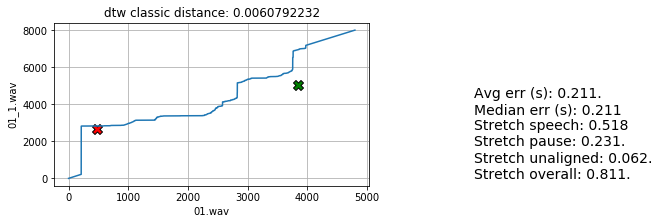

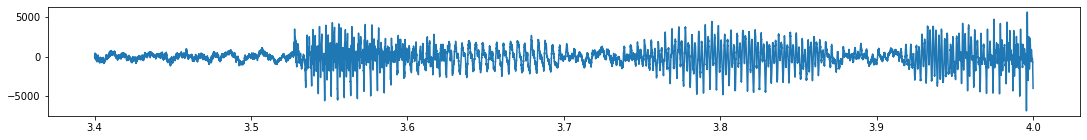

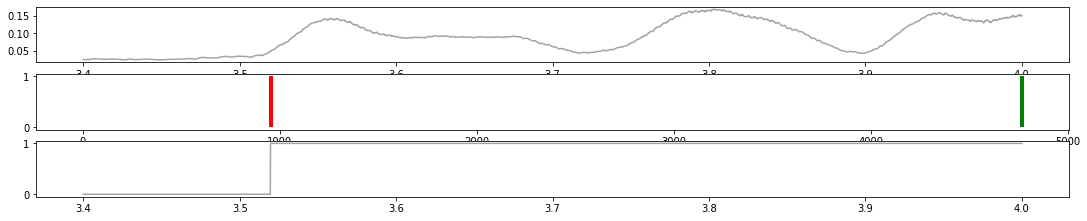

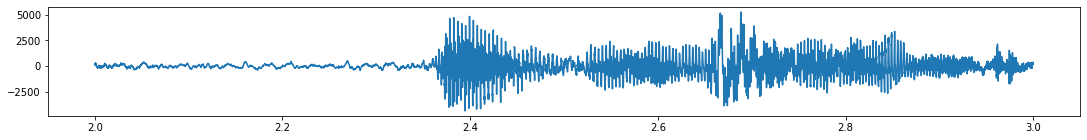

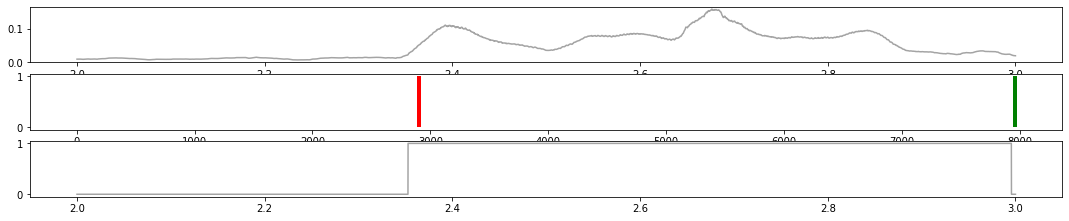

In [83]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 4
file2, seg2_1, seg2_2 = "01_1.wav", 2, 3

time1_lst = [3.46, 3.88]
time2_lst = [2.33, 2.63]
xlabel = file1;  ylabel = file2

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

[957, 6058, 6772, 7768, 8245, 11079, 11842, 12646, 12646, 14344, 14933, 16604, 17264, 17665, 18758, 20404]
[2902, 6996, 8153, 8915, 9684, 11303, 12743, 13998, 14314, 16061, 16882, 17501, 17536, 17536, 18425, 20225]


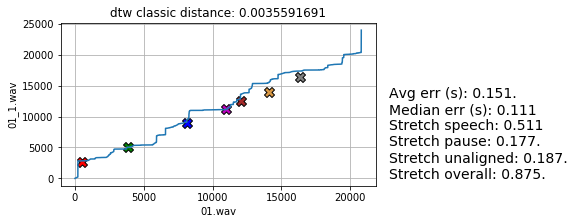

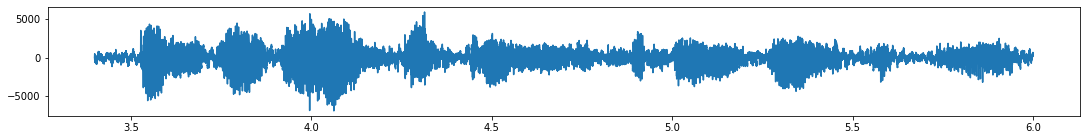

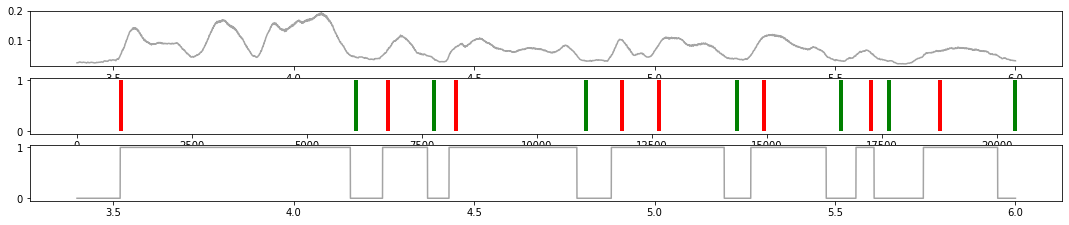

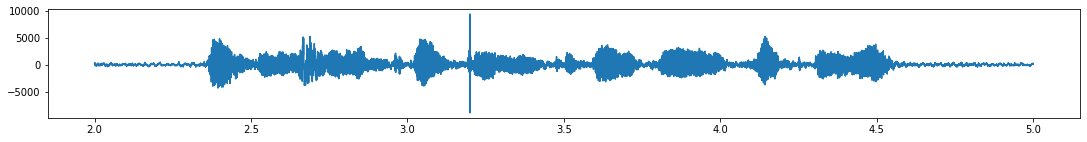

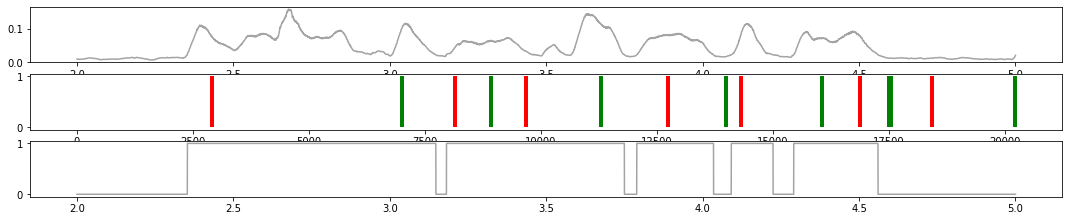

In [84]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]
xlabel = file1;  ylabel = file2

#setup.play_samples(play_x, play_y, play_sr)

output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

In [16]:
a = {'index in curve 3575 speech': [957, 2902], 'index in curve 10731 pause': [4765, 7965]}
print(list(a.values()))

[[957, 2902], [4765, 7965]]


In [17]:
dat1 = pd.DataFrame({'s': [9,5]})
dat2 = pd.DataFrame({'p': [7,6]})
dat1.join(dat2)

person1 = {'type': 1, 'name': 'Jhon', 'surname': 'Smith', 'phone': '555-1234'}
person2 = {'type': 1, 'name': 'Jannette', 'surname': 'Jhonson', 'credit': 1000000.00}
pd.DataFrame([person1, person2])

data = np.array([[10,20,30], [20,30,60], [30,60,90]])
dataPd = pd.DataFrame(data = data)
    
dataPd

,0,1,2
0,10,20,30
1,20,30,60
2,30,60,90


[957, 6058, 6772, 7768, 8245, 11079, 11842, 12646, 12646, 14344, 14933, 16604, 17264, 17665, 18758, 20404]
[2902, 6996, 8153, 8915, 9684, 11303, 12743, 13998, 14314, 16061, 16882, 17501, 17536, 17536, 18425, 20225]


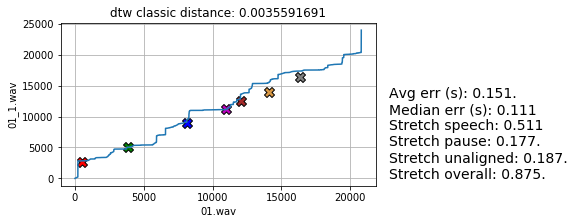

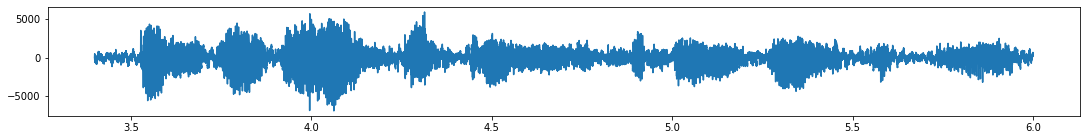

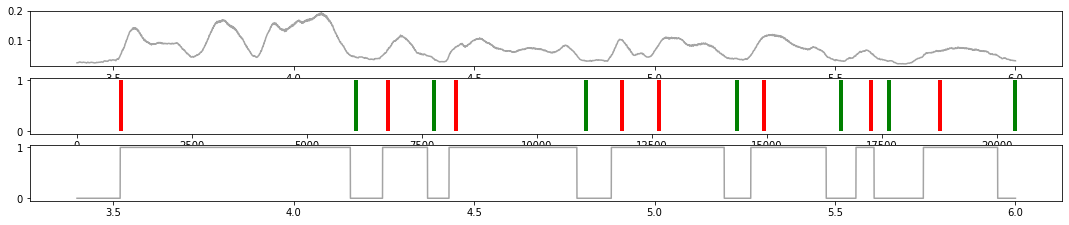

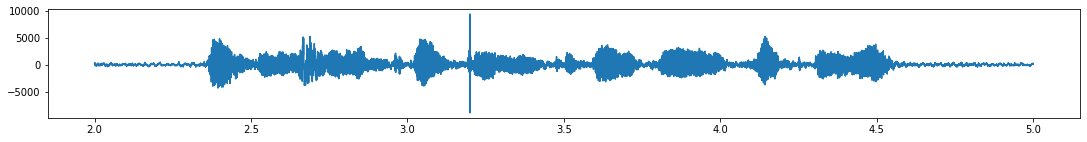

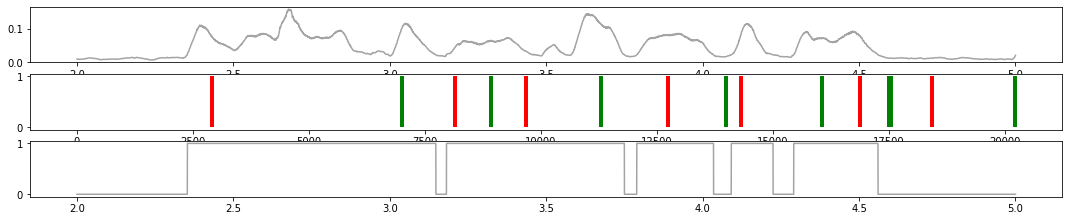

In [85]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_1.wav", 2, 5

time1_lst = [3.46, 3.88, 4.42, 4.77, 4.91, 5.16, 5.44]
time2_lst = [2.33, 2.63, 3.12, 3.4, 3.57, 3.74, 4.06]

xlabel = file1;  ylabel = file2

#setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

In [ ]:
import json

data = {}
data['people'] = []
data['people'].append({
    'name': 'Scott',
    'website': 'stackabuse.com',
    'from': 'Nebraska'
})
data['people'].append({
    'name': 'Larry',
    'website': 'google.com',
    'from': 'Michigan'
})
data['people'].append({
    'name': 'Tim',
    'website': 'apple.com',
    'from': 'Alabama',
    'hi': 2020
})

with open('data.txt', 'w') as outfile:
    json.dump(data, outfile)
    
with open('data.txt') as json_file:
    data = json.load(json_file)
    for p in data['people']:
        print('Name: ' + p['name'])
        print('Website: ' + p['website'])
        print('From: ' + p['from'])
        print('')    

# Bamboo vs B B Bamboo 01 vs. repeat-syllable01

In [ ]:
# test
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 3.5

input_min_amp1, input_min_amp2  = 500, 530
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, input_min_amp1 = 500, input_min_amp2 = 520, input_min_pause = 10)

n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46]
time2_lst = [2.88]
# setup.play_samples(play_x, play_y, play_sr)
output()

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 3.5

input_min_amp1, input_min_amp2  = 500, 530
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46]
time2_lst = [2.88]
# setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo vs Bamboo: 01 vs. test2

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "test2.wav", 0, 2
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46]
time2_lst = [1.43]

setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo walls are vs B B Bamboo walls are: 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.2
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 4.1
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16]
time2_lst = [2.88, 3.6, 4.07]

# setup.play_samples(play_x, play_y, play_sr)
output()

# Test - Bamboo walls vs Bamboo + pause + walls test2 vs test1

In [ ]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test1.wav", 1, 6
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [1.43, 2.01]
time2_lst = [1.37, 4.56]

setup.play_samples(play_x, play_y, play_sr)
output()

# Test - Bamboo walls test2 vs test3

In [ ]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test3.wav", 1, 6
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [1.43, 2.01]
time2_lst = [1.37, 4.56]

setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo walls are getting vs B B Bamboo ~ : 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1.5, 4.4
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16, 4.42]
time2_lst = [2.88, 3.6, 4.07, 4.3]

setup.play_samples(play_x, play_y, play_sr)
output()

# without stuttering

# Bamboo walls are : 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.2
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.1
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16]
time2_lst = [2.88, 3.6, 4.07]

setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo vs Bamboo 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 3.9
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 3.5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46]
time2_lst = [2.88]

In [ ]:
setup.play_samples(play_x, play_y, play_sr)

In [ ]:
output()

# Bamboo walls vs Bamboo walls : 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.1
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 3.8
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88]
time2_lst = [2.88, 3.6]

In [ ]:
setup.play_samples(play_x, play_y, play_sr)

In [ ]:
output()

# Bamboo walls are : 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.2
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.1
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16]
time2_lst = [2.88, 3.6, 4.07]

setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo walls are getting : 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 4.6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.4
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16, 4.42]
time2_lst = [2.88, 3.6, 4.07, 4.3]

setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo walls are getting to be : 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 4.8
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, input_min_pause = 50, input_min_amp1 = 500, input_min_amp2 = 250)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88]
time2_lst = [2.88, 3.6, 4.07, 4.3, 4.58, 4.75]

setup.play_samples(play_x, play_y, play_sr)
output()

# Bamboo walls are getting to be very popular  : 01 vs. repeat-syllable01(po po popular)

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.3, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 2.7, 6.6
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr, input_min_pause = 50, input_min_amp1 = 500, input_min_amp2 = 250)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88, 5.16, 5.44]
time2_lst = [2.88, 3.6, 4.07, 4.3, 4.58, 4.75, 4.98, 6.10]

setup.play_samples(play_x, play_y, play_sr)
output()

# TORGO: Except in the winter

In [ ]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 2, 3.7
file2, seg2_1, seg2_2 = "torgo-patient.wav", 2.5, 5

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr,  input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 50)

n_timestamps_1, n_timestamps_2 = len(x), len(y)

xlabel = "Except in the winter - healthy" ;  ylabel = "Except in the winter - patient"
time1_lst = [2.34, 2.86, 3.03, 3.26] ; time2_lst = [2.8, 3.86, 4.03, 4.20]

In [ ]:
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Torgo: when the ooze or snow or ice prevents

In [ ]:
file1, seg1_1, seg1_2 = "torgo-healthy.wav", 3.7, 6.50
file2, seg2_1, seg2_2 = "torgo-patient.wav", 5, 11.38
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.94, 4.03, 4.38, 4.8, 5.1, 5.54, 5.73, 6.18] ;
time2_lst = [7.07, 7.26, 7.78, 8.21, 8.53, 9.57, 9.9, 10.76]
xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_2

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.42, 4.77, 4.88, 5.16, 5.44] ;
time2_lst = [2.24, 2.72, 3.18, 3.46, 3.59, 3.84, 4.16]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01 vs. 01_3

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_3

In [ ]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_2 vs. 01_3

In [ ]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "01_3.wav", 2, 4.7
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)

time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_1 vs. 01_2

In [ ]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 5
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]


xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - perfect alignment - Normal v.s. Normal 01_3 vs. 01_2

In [ ]:
file1, seg1_1, seg1_2 = "01_3.wav", 2, 4.7
file2, seg2_1, seg2_2 = "01_2.wav", 2, 5
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.4, 3.57, 3.74, 4.06]
time2_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]


xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - normal vs. slightly slow: 01 vs 02: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "02.wav", 1.7, 5

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [1.74, 2.42, 2.92, 3.52, 3.75, 3.88, 4.29, 4.48]

xlabel = file1;  ylabel = file2
# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs. short pauses: 01 vs 05: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "05.wav", 1.4, 6

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [1.45, 1.83, 2.92, 3.17, 3.5, 3.64, 4.78, 5.09]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo - normal vs. repeat part of word + pauses: 01 vs pause_m01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "pause_m01.wav", 1.5, 13

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [4.52, 5.11, 9.18, 9.45, 9.82, 9.95, 11.06, 11.30]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Stutter 01_1 vs repeat-syllable01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Stutter 01_2 vs repeat-syllable01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 4.5
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.4, 6
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] 
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = file1;  ylabel = file2
# setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01_1 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_1.wav", 2, 4.1
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.33, 2.63, 2.87, 3.12, 3.40, 3.57, 3.74, 4.06]
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01_2 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_2.wav", 2, 5
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.28, 2.72, 2.93, 3.18, 3.51, 3.66, 3.84, 4.11]
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01_3 vs 02_1: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01_3.wav", 2, 4
file2, seg2_1, seg2_2 = "02_1.wav", 2.5, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [2.06, 2.45, 2.7, 2.94, 3.23, 3.41, 3.62, 3.98];
time2_lst = [3.23, 3.90, 4.61, 4.97, 5.27, 5.45, 6.19, 6.57]
xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Normal vs Slower: 01 vs long_w01: Bamboo walls are getting to be very popular

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 2, 6
file2, seg2_1, seg2_2 = "long_w01.wav", 1.5, 21

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.91, 5.21, 5.47] ;
time2_lst = [1.61, 6.12, 8.73, 11.11, 13.33, 15.80, 18.30, 20.72]
xlabel = file1;  ylabel = file2
setup.play_samples(play_x, play_y, play_sr)
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# Bamboo walls: test2 vs test1

In [ ]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test1.wav", 1, 6
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [1.43, 2.01]
time2_lst = [1.37, 4.56]

# setup.play_samples(play_x, play_y, play_sr)
output()

In [ ]:
file1, seg1_1, seg1_2 = "test2.wav", 0, 3
file2, seg2_1, seg2_2 = "test3.wav", 1, 6
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [1.43, 2.01]
time2_lst = [1.57, 2.14]

setup.play_samples(play_x, play_y, play_sr)
output()

# Very Popular vs Very Po Po Popular: 01 vs repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 5.2, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 5, 6.6
play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
xlabel = file1 ;  ylabel = file2
time1_lst = [5.44]
time2_lst = [6.1]

setup.play_samples(play_x, play_y, play_sr)
output()

# Normal vs Stutter: B B Bamboo walls are getting to be very po po popular 01 vs. repeat-syllable01

In [ ]:
file1, seg1_1, seg1_2 = "01.wav", 3.46, 6
file2, seg2_1, seg2_2 = "repeat-syllable01.wav", 1, 7

play_x, play_y, sr, x, y, speech_x, speech_y = make_samples(input_min_amp1, input_min_amp2, file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, sr)
n_timestamps_1, n_timestamps_2 = len(x), len(y)
time1_lst = [3.46, 3.88, 4.16, 4.42, 4.77, 4.88, 5.16, 5.44] 
time2_lst = [2.97, 3.6, 4.07, 4.30, 4.58, 4.75, 4.98, 6.1]

xlabel = file1;  ylabel = file2

In [ ]:
setup.play_samples(play_x, play_y, play_sr)

In [ ]:
output(input_min_amp1 = 500, input_min_amp2 = 250, input_min_pause = 30);

# other random stuff

In [ ]:
a = [1, 2, 3, 5, 6, 7, 10, 11, 12, 16, 17, 18, 1757, 1758, 1759, 1760, 1761, 1762]
res = []
res.append(a[0])
for i in range(1, len(a)-1):
    if a[i] - a[i-1] == 1 and a[i+1] - a[i] == 1:
        pass
    else:
        res.append(a[i])

res.append(a[len(a)-1])
print(res)